<a href="https://colab.research.google.com/github/ADHIL-VENGAT/CE888-DataScience-and-Decision-making/blob/main/lab4/my_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [122]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import Image
np.set_printoptions(precision = 3)

import itertools

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import SGDRegressor, BayesianRidge
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.metrics import SCORERS
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.dummy import DummyRegressor, DummyClassifier

In [58]:
df = pd.read_csv("https://raw.githubusercontent.com/albanda/CE888/master/lab4-recommender/jester-data-1.csv",header = None)
df

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,74,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,...,2.82,99.00,99.00,99.00,99.00,99.00,-5.63,99.00,99.00,99.00
1,100,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,...,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,49,99.00,99.00,99.00,99.00,9.03,9.27,9.03,9.27,99.00,...,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00
3,48,99.00,8.35,99.00,99.00,1.80,8.16,-2.82,6.21,99.00,...,99.00,99.00,99.00,0.53,99.00,99.00,99.00,99.00,99.00,99.00
4,91,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,...,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24978,100,0.44,7.43,9.08,2.33,3.20,6.75,-8.79,-0.53,-8.74,...,8.83,-1.21,9.22,-6.70,8.45,9.03,6.55,8.69,8.79,7.43
24979,91,9.13,-8.16,8.59,9.08,0.87,-8.93,-3.50,5.78,-8.11,...,-1.17,-5.73,-1.46,0.24,9.22,-8.20,-7.23,-8.59,9.13,8.45
24980,39,99.00,99.00,99.00,99.00,-7.77,99.00,6.70,-6.75,99.00,...,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00
24981,37,99.00,99.00,99.00,99.00,-9.71,99.00,4.56,-8.30,99.00,...,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00


In [59]:
#Replacing 99 with nan
def readData(filename):
  df = pd.read_csv("https://raw.githubusercontent.com/albanda/CE888/master/lab4-recommender/jester-data-1.csv",header = None)
  df
  DataLabels =df.columns
  # ==== trying to replace ? with Nan using na_values
  rawfile = pd.read_csv(filename, header=None, names=DataLabels, na_values=["99"])

  #========trying to replace ?
  rawfile.replace("99", "NaN")
  return rawfile
df = readData("https://raw.githubusercontent.com/albanda/CE888/master/lab4-recommender/jester-data-1.csv")
df

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,74.0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,...,2.82,NaN,NaN,NaN,NaN,NaN,-5.63,NaN,NaN,NaN
1,100.0,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,...,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,49.0,NaN,NaN,NaN,NaN,9.03,9.27,9.03,9.27,NaN,...,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN
3,48.0,NaN,8.35,NaN,NaN,1.80,8.16,-2.82,6.21,NaN,...,NaN,NaN,NaN,0.53,NaN,NaN,NaN,NaN,NaN,NaN
4,91.0,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,...,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24978,100.0,0.44,7.43,9.08,2.33,3.20,6.75,-8.79,-0.53,-8.74,...,8.83,-1.21,9.22,-6.70,8.45,9.03,6.55,8.69,8.79,7.43
24979,91.0,9.13,-8.16,8.59,9.08,0.87,-8.93,-3.50,5.78,-8.11,...,-1.17,-5.73,-1.46,0.24,9.22,-8.20,-7.23,-8.59,9.13,8.45
24980,39.0,NaN,NaN,NaN,NaN,-7.77,NaN,6.70,-6.75,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24981,37.0,NaN,NaN,NaN,NaN,-9.71,NaN,4.56,-8.30,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24983 entries, 0 to 24982
Columns: 101 entries, 0 to 100
dtypes: float64(101)
memory usage: 19.3 MB


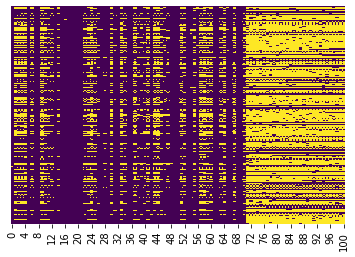

In [60]:
df.info()
#Cheching for nan values
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [67]:
# Dropping number of jokes rated by users
df = df.drop(axis=0, columns=0)

KeyError: ignored

In [68]:
df

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,...,2.82,NaN,NaN,NaN,NaN,NaN,-5.63,NaN,NaN,NaN
1,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,...,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,NaN,NaN,NaN,NaN,9.03,9.27,9.03,9.27,NaN,NaN,...,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,8.35,NaN,NaN,1.80,8.16,-2.82,6.21,NaN,1.84,...,NaN,NaN,NaN,0.53,NaN,NaN,NaN,NaN,NaN,NaN
4,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,...,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24978,0.44,7.43,9.08,2.33,3.20,6.75,-8.79,-0.53,-8.74,7.23,...,8.83,-1.21,9.22,-6.70,8.45,9.03,6.55,8.69,8.79,7.43
24979,9.13,-8.16,8.59,9.08,0.87,-8.93,-3.50,5.78,-8.11,4.90,...,-1.17,-5.73,-1.46,0.24,9.22,-8.20,-7.23,-8.59,9.13,8.45
24980,NaN,NaN,NaN,NaN,-7.77,NaN,6.70,-6.75,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24981,NaN,NaN,NaN,NaN,-9.71,NaN,4.56,-8.30,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
df.describe()

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
count,16452.000000,18184.000000,16642.000000,15608.000000,24977.000000,20431.000000,24976.000000,24981.000000,15752.000000,20324.000000,...,9672.000000,9889.000000,9988.000000,10200.000000,10265.000000,10370.000000,10520.000000,10666.000000,10910.000000,9943.000000
mean,0.904573,0.208460,0.316574,-1.449114,0.403556,1.594447,-0.429662,-0.624085,-0.557031,1.301231,...,2.038527,1.179744,2.504041,1.173482,1.039130,1.528003,1.673750,0.767692,-0.031244,1.354711
std,5.171798,5.597327,5.399806,5.234654,5.255700,4.900540,5.495931,4.929144,5.162224,5.087359,...,5.060445,5.127291,4.611339,5.140307,5.167043,4.852069,5.025076,5.393833,5.176806,5.300409
min,-9.950000,-9.950000,-9.950000,-9.950000,-9.950000,-9.950000,-9.950000,-9.950000,-9.950000,-9.950000,...,-9.950000,-9.950000,-9.950000,-9.950000,-9.950000,-9.950000,-9.950000,-9.950000,-9.950000,-9.950000
25%,-2.670000,-4.420000,-4.030000,-5.870000,-3.690000,-1.310000,-5.290000,-4.610000,-4.760000,-2.090000,...,-0.932500,-2.380000,-0.100000,-2.280000,-2.570000,-1.347500,-1.170000,-3.400000,-4.170000,-2.330000
50%,1.600000,0.830000,0.780000,-1.460000,1.120000,2.230000,-0.050000,-0.290000,-0.190000,1.940000,...,2.860000,1.800000,3.160000,1.750000,1.650000,2.140000,2.480000,1.460000,0.290000,2.140000
75%,4.900000,4.820000,4.660000,2.520000,4.470000,5.440000,3.880000,3.060000,3.300000,5.390000,...,6.120000,5.290000,6.070000,5.290000,5.100000,5.277500,5.630000,5.150000,3.980000,5.730000
max,9.370000,9.370000,9.370000,9.370000,9.370000,9.470000,9.610000,9.760000,9.900000,9.370000,...,9.560000,9.420000,9.370000,9.420000,9.370000,9.370000,9.370000,9.370000,9.370000,9.370000


In [81]:
df.mean()

1      0.904573
2      0.208460
3      0.316574
4     -1.449114
5      0.403556
         ...   
96     1.528003
97     1.673750
98     0.767692
99    -0.031244
100    1.354711
Length: 100, dtype: float64

In [117]:
#Top 5
mean =df.mean().values.tolist()

top5 =sorted(range(len(mean)), key=lambda i: mean[i])[-5:]
print(' Average mean of top rated 5 jokes')
for i in range(len(top5)):
  print('Mean of joke No.',top5[i],' ----> ',mean[top5[i]])

 Average mean of top rated 5 jokes
Mean of joke No. 31  ---->  3.155987654320997
Mean of joke No. 26  ---->  3.1898213138451355
Mean of joke No. 35  ---->  3.3125003004205738
Mean of joke No. 88  ---->  3.5747197825178025
Mean of joke No. 49  ---->  3.6650848950824937


In [121]:
#Worst 5
mean =df.mean().values.tolist()

top5 =sorted(range(len(mean)),reverse = True, key=lambda i: mean[i])[-5:]
print(' Average mean of worst rated 5 jokes')
for i in range(len(top5)):
  print('Mean of joke No.',top5[i],' ----> ',mean[top5[i]])

 Average mean of worst rated 5 jokes
Mean of joke No. 12  ---->  -1.762881790160528
Mean of joke No. 56  ---->  -1.9906636198585173
Mean of joke No. 43  ---->  -2.1118909562959822
Mean of joke No. 15  ---->  -3.104818018018001
Mean of joke No. 57  ---->  -3.8338796373689923


# **Validation Set**

In [126]:
# Validation set
arr = df.values
print(arr.shape)


(24983, 100)


In [127]:
rated = np.where(arr!=99)
print(len(rated[0]), rated[1].shape)


2498300 (2498300,)


In [ ]:
def replace(orig, percentage=0.1):
  """
  Replaces 'percentage'% of the original values in 'orig' with 99's
  :param orig: original data array
  :param percentage: percentage of values to replace (0<percentage<1)
  """
  new_data = orig.copy()
  rated = np.where(arr!=99)
  n_rated = len(rated[0])
  idx = np.random.choice(n_rated, size=int(percentage*n_rated), replace=False)
  new_data[rated[0][idx], rated[1][idx]] = 99
  return new_data, (rated[0][idx], rated[1][idx])


In [133]:
new_arr, idx = replace(arr, 0.1)

In [140]:
#Dropping all nana rows to geg the 10% validation set
df_val = pd.DataFrame(new_arr)
df_val=df_val.dropna()
df_val

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
1,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,...,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
5,-6.17,-3.54,0.44,-8.50,-7.09,99.00,-8.69,-0.87,-6.65,-1.80,...,-3.54,-6.89,-0.68,-2.96,-2.18,99.00,99.00,-9.08,-5.05,-3.45
7,6.84,3.16,9.17,-6.21,-8.16,-1.70,9.27,1.41,-5.19,-4.42,...,7.23,-1.12,-0.10,-5.68,-3.16,-3.35,2.14,99.00,1.31,0.00
8,-3.79,-3.54,-9.42,-6.89,-8.74,99.00,-5.29,-8.93,-7.86,99.00,...,4.37,-0.29,4.17,-0.29,-0.29,-0.29,-0.29,-0.29,-3.40,-4.95
11,1.31,99.00,2.57,-2.38,0.73,0.73,-0.97,5.00,-7.23,-1.36,...,99.00,1.70,0.29,-3.30,3.45,5.44,4.08,2.48,4.51,4.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24958,-2.91,-1.89,-2.86,-1.99,-7.52,-4.66,99.00,6.02,-3.83,-4.42,...,-5.68,-5.68,-2.82,-4.61,-4.37,-3.93,-0.15,-0.87,-1.99,-1.80
24962,4.85,3.83,4.13,-5.53,2.14,-4.66,0.10,-1.75,0.44,0.39,...,-8.30,-9.56,99.00,-3.50,2.04,-6.31,-4.42,3.06,-1.26,-6.36
24967,-0.29,-0.29,-0.29,-0.29,-1.84,0.10,-3.01,-0.29,0.49,-0.29,...,0.29,0.87,3.79,0.68,0.87,4.17,0.29,1.46,-0.29,-0.68
24971,4.17,4.17,9.03,-0.29,2.04,3.79,99.00,-7.86,4.17,5.73,...,-0.68,7.28,4.95,99.00,3.20,-2.23,5.92,-0.29,-0.29,4.37


# **Latent factor modelling**

In [188]:
n_latent_factors = 2
data = df

user_ratings = data.values
# Initialise as random values
latent_user_preferences = np.random.random((user_ratings.shape[0], n_latent_factors))
latent_item_features = np.random.random((user_ratings.shape[1], n_latent_factors))

In [189]:
latent_item_features

array([[0.575, 0.234],
       [0.939, 0.45 ],
       [0.156, 0.685],
       [0.377, 0.175],
       [0.916, 0.031],
       [0.888, 0.522],
       [0.357, 0.775],
       [0.766, 0.258],
       [0.789, 0.855],
       [0.263, 0.852],
       [0.755, 0.677],
       [0.436, 0.689],
       [0.019, 0.184],
       [0.783, 0.03 ],
       [0.777, 0.648],
       [0.416, 0.851],
       [0.669, 0.364],
       [0.92 , 0.737],
       [0.36 , 0.366],
       [0.22 , 0.022],
       [0.766, 0.68 ],
       [0.492, 0.081],
       [0.925, 0.459],
       [0.221, 0.71 ],
       [0.786, 0.995],
       [0.932, 0.249],
       [0.162, 0.732],
       [0.281, 0.354],
       [0.963, 0.43 ],
       [0.498, 0.846],
       [0.683, 0.925],
       [0.457, 0.93 ],
       [0.446, 0.393],
       [0.342, 0.879],
       [0.563, 0.545],
       [0.641, 0.859],
       [0.265, 0.426],
       [0.047, 0.984],
       [0.916, 0.849],
       [0.147, 0.902],
       [0.067, 0.862],
       [0.063, 0.329],
       [0.317, 0.311],
       [0.3

In [190]:
latent_user_preferences

array([[0.646, 0.665],
       [0.495, 0.657],
       [0.352, 0.603],
       ...,
       [0.632, 0.664],
       [0.708, 0.228],
       [0.219, 0.899]])

In [191]:
for user_id in range(latent_user_preferences.shape[0]):
  print(user_id)
  break
print()


0



In [192]:
latent_item_features.shape

(100, 2)

In [193]:
def predict_rating(user_id, item_id):
    """ Predict a rating given a user_id and an item_id.
    """
    user_preference = latent_user_preferences[user_id]
    item_preference = latent_item_features[item_id]
    return user_preference.dot(item_preference)


def train(user_id, item_id, rating, alpha=0.0001):
    #print(item_id)
    predicted_rating = predict_rating(user_id, item_id)
    err =  predicted_rating - rating
    #print(err)
    user_pref_values = latent_user_preferences[user_id]
    latent_user_preferences[user_id] -= alpha * err * latent_item_features[item_id]
    latent_item_features[item_id] -= alpha * err * user_pref_values
    return err
    

def sgd(iterations):
    """ Iterate over all users and all items and train for 
        a certain number of iterations
    """
    mse_history = []
    for iteration in range(iterations):
        error = []
        
        ### YOUR CODE (inner loop) HERE
        for user_id in range(latent_user_preferences.shape[0]):
            for item_id in range(latent_item_features.shape[0]):
                rating = user_ratings[user_id, item_id]
                if not np.isnan(rating):
                    err = train(user_id, item_id, rating)
                    error.append(err)
        mse = (np.array(error) ** 2).mean()   
        if (iteration % 10000) == 0:
            print('Iteration %d/%d:\tMSE=%.6f' % (iteration, iterations, mse))
            mse_history.append(mse)
    return mse_history

In [ ]:
np.random.seed(20)

n_latent_factors = 2
latent_user_preferences = np.random.random((user_ratings.shape[0], n_latent_factors))
latent_item_features = np.random.random((user_ratings.shape[1], n_latent_factors))
hist = sgd(100)

Iteration 0/100:	MSE=26.087353


Iteration 0/10:	MSE=26.228906


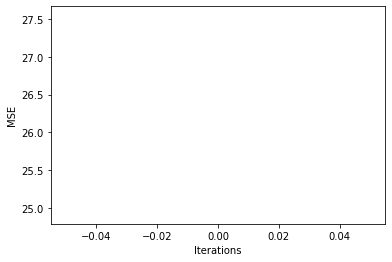

In [145]:
num_iter = 10
hist = sgd(num_iter)  # Note how the MSE decreases with the number of iterations
plt.figure()
plt.plot(np.arange(0, num_iter, 10000), hist)
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.show()